# Data Science Showcase

In this data science showcase, we'll be exploring the techniques we've developed over the semester, as well as the variety of applications in which the tools can be utilized to gain new insights and interests!

First, we will be importing all of the libraries we need for the project below:

In [1]:
!pip install langdetect

Note: This first import is retroactive, as a technique used in the project became deprecated after the project was completed. As I wish to preserve the coding that I did at the time instead of changing it, the deprecation warning is being ignored to maintain the original style of the notebook.

In [2]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import langdetect
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Linear Regression with Wines
Next! Our first showcase will be exploring wine quality, and how it can be measured against different attributes of the wine! To start, we will open our data and do an initial cleanse.

In [4]:
df = pd.read_csv('winequality-red.csv', sep=";")

for column in df.columns:
    df[column].astype(float)

df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Next, let's try a preliminary visualization! We'll take the attributes of the alcohol content of the wine and measure it against the overall quality.

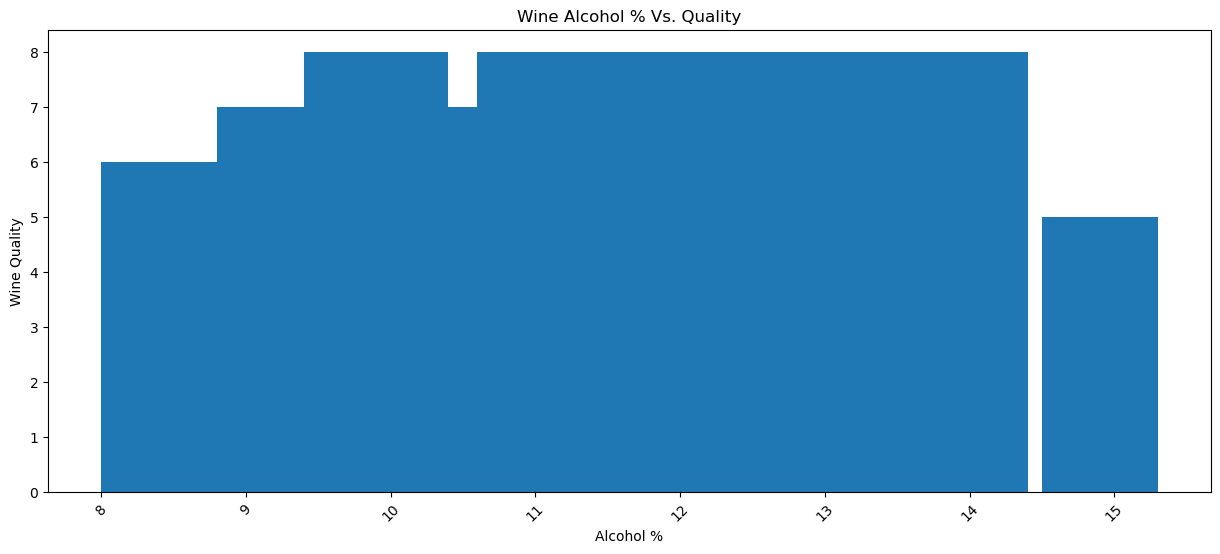

In [5]:
plt.figure(figsize=(15,6))
plt.title('Wine Alcohol % Vs. Quality')
plt.xticks(rotation=45)
plt.xlabel('Alcohol %')
plt.ylabel('Wine Quality')
plt.bar(df['alcohol'], df['quality'])
plt.show()

Well, it seems clear from this visualization that a bar plot may not be the most effective way to visualize the relationship between two attributes of the wine. Alternatively, we can try to use linear regression to plot the attributes of the wine and see how it looks!

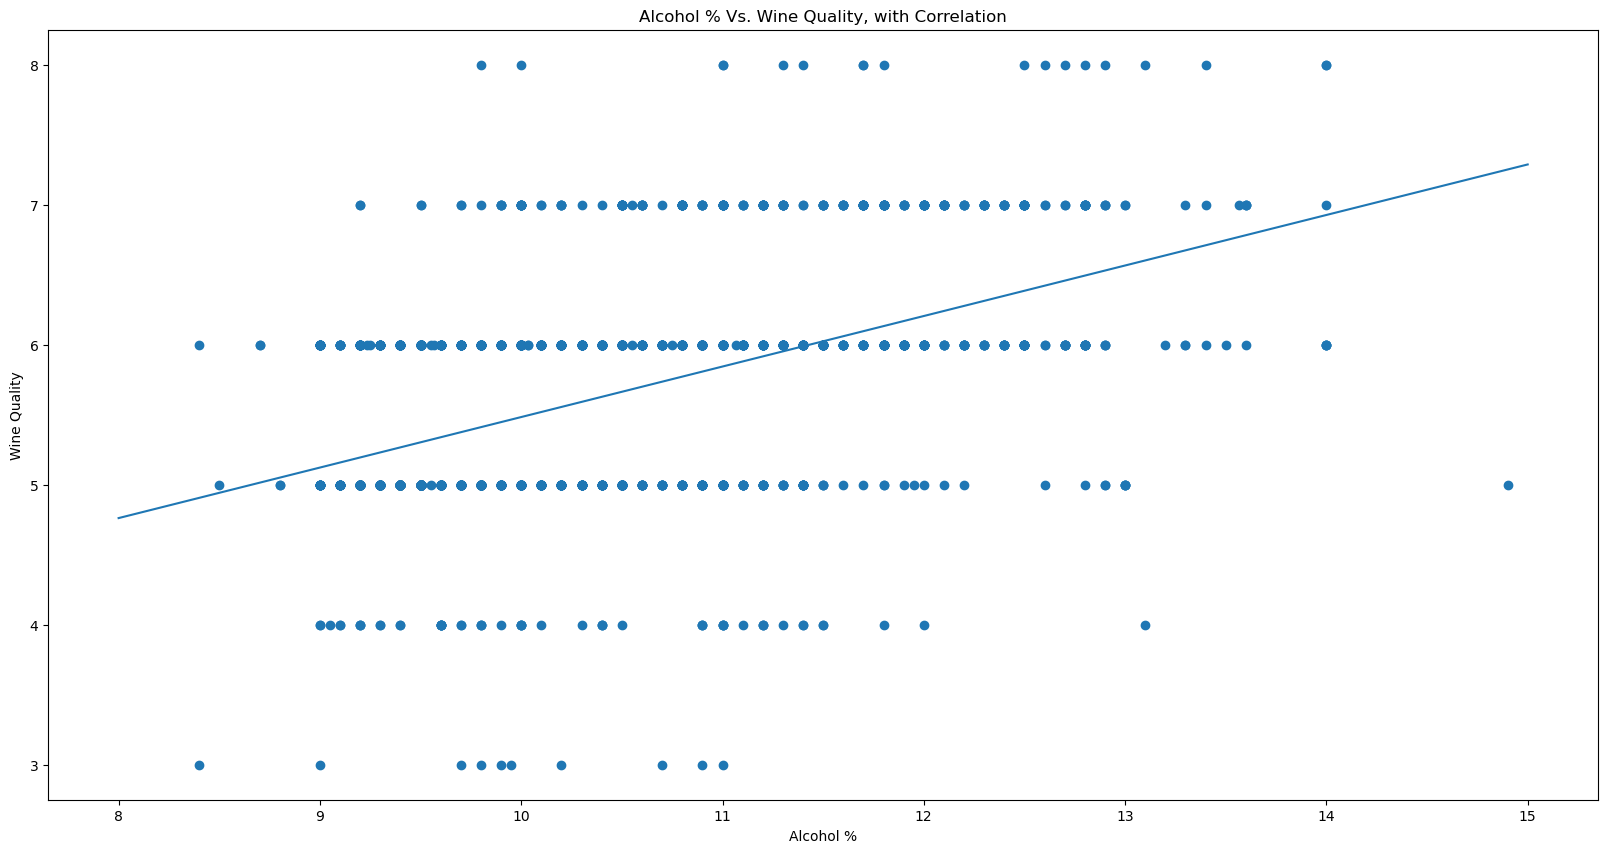

In [6]:
model = LinearRegression(fit_intercept=True)
x = df[['alcohol']]
y = df[['quality']]
model.fit(x.astype(float).values, y.astype(float).values)
u = np.linspace(8, 15, 50)
v = model.predict(u[:, np.newaxis])
_, ax = plt.subplots(figsize=(20, 10))
ax.scatter(df['alcohol'].astype(float).values, y.astype(float).values)
ax.set(xlabel = 'Alcohol %', ylabel = 'Wine Quality', title='Alcohol % Vs. Wine Quality, with Correlation')
ax.plot(u,v)


Now that we've modeled alcohol against quality using linear regression, and mapped it against the values, we can see that there appears to only be a vague correlation. This can be further studied by analyzing the R-squared value of the model, which tells us how often predicted values match occurring values.

In [7]:
r2_score = model.score(x.values, y.values)
print(f"R-squared value: {r2_score}")

R-squared value: 0.22673436811275482


The low R-squared value shows that alcohol content is likely not a reliable measure of wine quality. A more efficient way to determine what might be the most reliable indicator would be to determine the R-squared statistics of each attribute against quality, and then measure the highest. Let's try that!

<BarContainer object of 11 artists>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

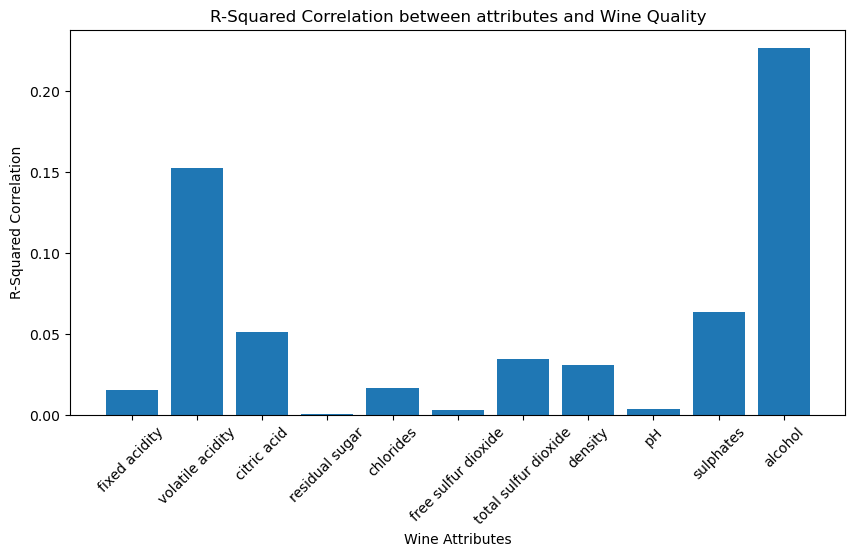

In [8]:
new_model = LinearRegression(fit_intercept=True)

highest_correlation = 0
highest_name = ''
r2_list = []
for column in df.columns:
    if column == 'quality':
        break
    x = df[[column]]
    y = df[['quality']]
    new_model.fit(x.astype(float).values, y.astype(float).values)
    r2_score = new_model.score(x.values, y.values)
    r2_list.append(r2_score)
    if highest_correlation < r2_score:
        highest_correlation = r2_score
        highest_name = column

        plt.figure(figsize=(10,5))
plt.title("R-Squared Correlation between attributes and Wine Quality")   
plt.xlabel('Wine Attributes')
plt.ylabel('R-Squared Correlation')
plt.xticks(rotation=45)
plt.bar(df.columns[0:11], r2_list)


Wow! In a surprising result, it seems our highest correlation WAS alcohol content. This goes to show that it can always be hard to tell which two variables will be most correlated until you crunch the data! In the future, it would be beneficial to test various regression models to see if there is a more complex correlation to be established!

# Product Review Analysis

Next, we will be applying some of the NLP techniques learned this semester to product reviews! The purpose of this is to gauge the sentiment of different product reviews, and map them against their review scores!

We will be starting with reviews of shoes from Amazon UK. We will be removing many part of the dataset that aren't important for our purposes (such as Reviewer Names, Locations, IDs, etc.)

In [9]:
df = pd.read_csv('amazon_uk_shoes_products_dataset_2021_12.csv')

# This code will remove reviews where the purchase could not be verified, to increase accuracy of the model.
for i, value in enumerate(df["verified_purchase"]):
    if value == False:
        df.drop(index=i)
df['review_text'] = df['review_text'].str.lower().replace('[^A-Za-z ]', '', regex=True)
df = df.replace('', 'none')
df = df.replace(' ', 'none')
df = df.replace([np.nan], 'none')
df.reset_index()
df = df.drop(columns=['reviewer_name', 'review_date','helpful_count','uniq_id','scraped_at', 'verified_purchase'])
df

,url,product_name,review_title,review_text,review_rating
0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Love em,love these was looking for converses and these...,5.0
1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,The plastic ripped,the shoes are very cute but after the nd day o...,2.0
2,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Good quality,good quality,5.0
3,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Good,great,5.0
4,https://www.amazon.co.uk/dp/B08SW434MG,"GUESS Women's Bradly Gymnastics Shoe, White, 7 UK",PERFETTE!!,ho scelto il modello bianco con rifinitura die...,5.0
...,...,...,...,...,...
6818,https://www.amazon.co.uk/dp/B07TPYWFVN,"Clarks Vennor Wing, Men’s Low-Top Sneakers, Bl...",Schick und leicht,schicker schuh luft sich gut,5.0
6819,https://www.amazon.co.uk/dp/B07TPYWFVN,"Clarks Vennor Wing, Men’s Low-Top Sneakers, Bl...",EXCELLENT,mieux que je ne limaginais trs bonne taille bo...,5.0
6820,https://www.amazon.co.uk/dp/B084WB2D93,"Rohde Men's Tivoli-H Mule, 82 Anthracite, 12.5 UK",Einfach schöne Hausschuhe,habe sie als geschenk gekauft und sie sind seh...,5.0
6821,https://www.amazon.co.uk/dp/B084WB2D93,"Rohde Men's Tivoli-H Mule, 82 Anthracite, 12.5 UK",Langlebig.,trage diese hausschuhe fast zwei monate jeden ...,5.0


As we can see immediately in our review compilation, we have reviews that are not in English. For the sake of simplifying our analysis, we will have to enhance our pre-processing a bit by additionally removing reviews that aren't in English. Luckily, there is a python library designed to do just that!

In [10]:
for i, value in enumerate(df['review_text']):
    if value == 'none':
        df = df.drop(index=i)
        continue
    if langdetect.detect(value) != 'en':
        df = df.drop(index=i)
df = df.reset_index()        
df

,index,url,product_name,review_title,review_text,review_rating
0,0,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,Love em,love these was looking for converses and these...,5.0
1,1,https://www.amazon.co.uk/dp/B07SBX32T5,Klasified Women's Transparent Clear Sneaker Sh...,The plastic ripped,the shoes are very cute but after the nd day o...,2.0
2,14,https://www.amazon.co.uk/dp/B07S1XM3L7,"adidas Women's Retrorun Shoes Running, Core Bl...",Perfect right outta the box,true to size if between id probably go with yo...,5.0
3,15,https://www.amazon.co.uk/dp/B07S1XM3L7,"adidas Women's Retrorun Shoes Running, Core Bl...",Disappointed,this is the second pair i bought loved the fir...,2.0
4,16,https://www.amazon.co.uk/dp/B07S1XM3L7,"adidas Women's Retrorun Shoes Running, Core Bl...",Wow!,i love these shoes so much its my second pair ...,5.0
...,...,...,...,...,...,...
3784,6813,https://www.amazon.co.uk/dp/B06XFT2G2F,"Skechers Kids Boys' Nitrate-95358N Sneaker, Bl...",Great for early walkers,the only shoes after many tries that worked fo...,5.0
3785,6814,https://www.amazon.co.uk/dp/B06XFT2G2F,"Skechers Kids Boys' Nitrate-95358N Sneaker, Bl...",Three Stars,too narrow hard to get on for a toddler,3.0
3786,6815,https://www.amazon.co.uk/dp/B06XFT2G2F,"Skechers Kids Boys' Nitrate-95358N Sneaker, Bl...",Said they were very comfortable.,my son loves them said they were very comfortable,5.0
3787,6816,https://www.amazon.co.uk/dp/B06XFT2G2F,"Skechers Kids Boys' Nitrate-95358N Sneaker, Bl...",They are smaller than other shoes the same size,size but they are smaller than the size my s...,2.0


We've the data down by about 3,000 rows, and now we should only have reviews with ample data available in English. Great! Next, we can run sentiment analysis on the data, and use our previous linear regression to have a look at the relationship between the sentiment polarity and overall review score.

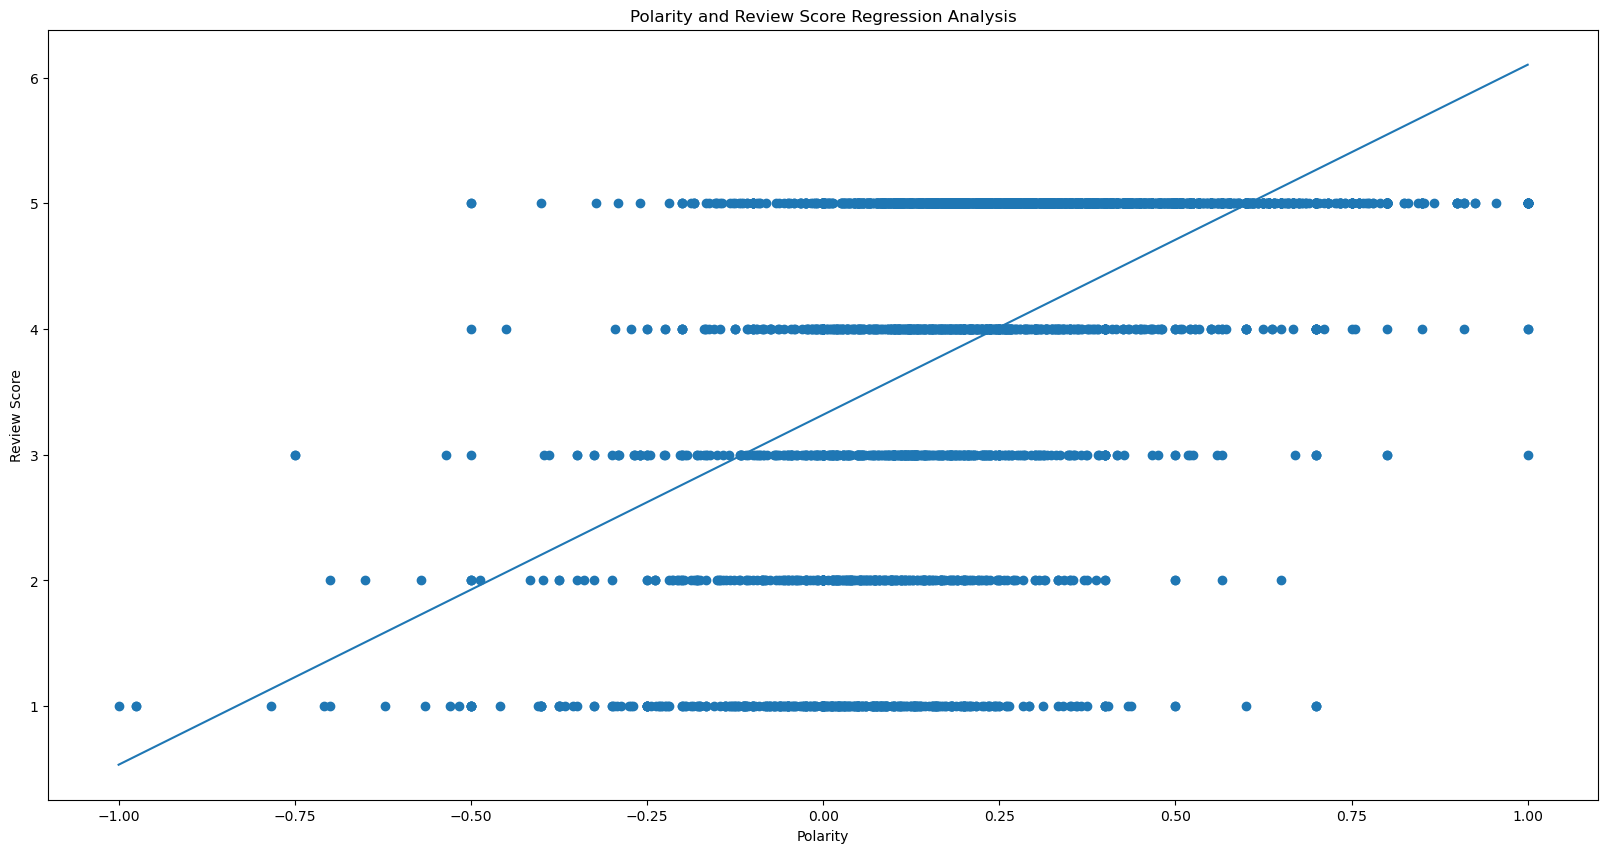

In [11]:
text_analysis = []
for i, value in enumerate(df['review_text']):
    analysis = TextBlob(value)
    text_analysis.append(float(analysis.sentiment.polarity))
y = df['review_rating'].astype(float)

model = LinearRegression(fit_intercept=True)
y = y.values
x = np.array(text_analysis)
x = x.reshape(-1,1)
y = y.reshape(-1,1)

model.fit(x, y)
u = np.linspace(-1, 1, 50)
v = model.predict(u[:, np.newaxis])
_, ax = plt.subplots(figsize=(20, 10))
ax.set(xlabel='Polarity', ylabel='Review Score', title='Polarity and Review Score Regression Analysis')
ax.scatter(x, y)
ax.plot(u,v)

This is an interesting look at the relationship between polarity and reviews! There may be a better way to visualize the relationship for something specific like sentiment analysis. To show this, we'll make a bar plot with aggregate polarity scores for each review score, to demonstrate.

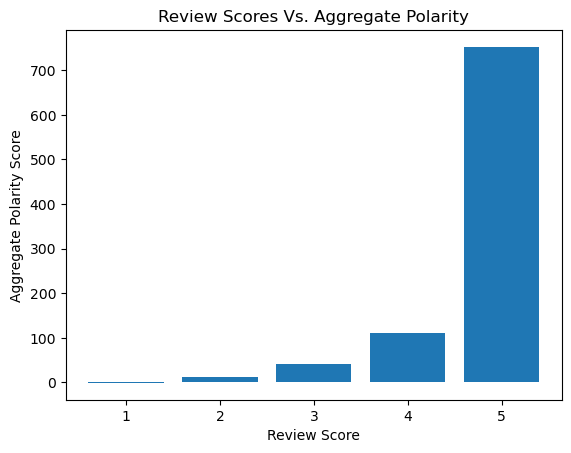

{5.0: 752.29, 2.0: 12.06, 1.0: -0.97, 4.0: 111.01, 3.0: 41.73}


In [12]:
bar_data = {}
for i, value in enumerate(df['review_rating']):
    if value not in bar_data:
        bar_data[value] = []
    bar_data[value].append(text_analysis[i])

for item in bar_data:
    x = round(sum(bar_data[item]),2)
    bar_data[item] = x

x = list(bar_data)
y = list(bar_data.values())

plt.xlabel('Review Score')
plt.ylabel('Aggregate Polarity Score')
plt.title('Review Scores Vs. Aggregate Polarity')
plt.bar(x, y)
plt.show()
print(bar_data)

So, as you can see, there are a variety of interesting ways that we can visualize the same data. This method is arguably more valuable, as you can see that as review scores are aggregated, the extremes have the most significant polarity, with 5 star ratings having a very high polarity and 1 star ratings having the only negative aggregate polarity.

# KNN Algorithms and Obesity

Our last analysis as part of this showcase will be exploring ability for KNN to correctly classify different attributes of an Obesity Dataset. For this study, we won't be manipulating the K-value so much as testing the same K value for different attributes, and seeing which may provide the most accurate results.

In [13]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

df

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,Female,1.620000,64.000000,no,no,2.0,3.0,no,no,2.000000,yes,0.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
1,21.000000,Female,1.520000,56.000000,Sometimes,no,3.0,3.0,yes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,23.000000,Male,1.800000,77.000000,Frequently,no,2.0,3.0,no,no,2.000000,yes,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
3,27.000000,Male,1.800000,87.000000,Frequently,no,3.0,3.0,no,no,2.000000,no,2.000000,0.000000,Sometimes,Walking,Overweight_Level_I
4,22.000000,Male,1.780000,89.800000,Sometimes,no,2.0,1.0,no,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,Female,1.710730,131.408528,Sometimes,yes,3.0,3.0,no,no,1.728139,yes,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,21.982942,Female,1.748584,133.742943,Sometimes,yes,3.0,3.0,no,no,2.005130,yes,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,22.524036,Female,1.752206,133.689352,Sometimes,yes,3.0,3.0,no,no,2.054193,yes,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,24.361936,Female,1.739450,133.346641,Sometimes,yes,3.0,3.0,no,no,2.852339,yes,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


To give context to a lot of the columns, here is this key, pulled directly from the Kaggle site where the data was obtained from:

FAVC : Feature, Binary, " Do you eat high caloric food frequently? "

FCVC : Feature, Integer, " Do you usually eat vegetables in your meals? "

NCP : Feature, Continuous, " How many main meals do you have daily? "

CAEC : Feature, Categorical, " Do you eat any food between meals? "

SMOKE : Feature, Binary, " Do you smoke? "

CH2O: Feature, Continuous, " How much water do you drink daily? "

SCC: Feature, Binary, " Do you monitor the calories you eat daily? "

FAF: Feature, Continuous, " How often do you have physical activity? "

TUE : Feature, Integer, " How much time do you use technological devices such as cell phone, videogames, television, computer and others? "

CALC : Feature, Categorical, " How often do you drink alcohol? "

MTRANS : Feature, Categorical, " Which transportation do you usually use? "

NObeyesdad : Target, Categorical, "Obesity level"

Additionally, there are several textual responses which we will need to quantify so they can be utilized in the dataset. We have responses such as "no" which we can quantify as 0, and "yes" which can be quantified as 1. These will be applied to boolean questions. Separately, there are responses such as "Sometimes", "Frequently", and "Always", which will be quantified as 1, 2, and 3, respectively. Lastly, we will drop columns that we cannot easily quantify, as we will not be using them in the analyses.

In [14]:
df = df.replace('no', 0)
df = df.replace('yes', 1)
df = df.replace('Sometimes', 1)
df = df.replace('Frequently', 2)
df = df.replace('Always', 3)
df = df = df.drop(columns=['Gender', 'MTRANS'])
# Renamed to ease graphing
df = df.rename(columns={"family_history_with_overweight":"FHIST"})
df

,Age,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,FHIST,FAF,TUE,CAEC,NObeyesdad
0,21.000000,1.620000,64.000000,0,0,2.0,3.0,0,0,2.000000,1,0.000000,1.000000,1,Normal_Weight
1,21.000000,1.520000,56.000000,1,0,3.0,3.0,1,1,3.000000,1,3.000000,0.000000,1,Normal_Weight
2,23.000000,1.800000,77.000000,2,0,2.0,3.0,0,0,2.000000,1,2.000000,1.000000,1,Normal_Weight
3,27.000000,1.800000,87.000000,2,0,3.0,3.0,0,0,2.000000,0,2.000000,0.000000,1,Overweight_Level_I
4,22.000000,1.780000,89.800000,1,0,2.0,1.0,0,0,2.000000,0,0.000000,0.000000,1,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,1.710730,131.408528,1,1,3.0,3.0,0,0,1.728139,1,1.676269,0.906247,1,Obesity_Type_III
2107,21.982942,1.748584,133.742943,1,1,3.0,3.0,0,0,2.005130,1,1.341390,0.599270,1,Obesity_Type_III
2108,22.524036,1.752206,133.689352,1,1,3.0,3.0,0,0,2.054193,1,1.414209,0.646288,1,Obesity_Type_III
2109,24.361936,1.739450,133.346641,1,1,3.0,3.0,0,0,2.852339,1,1.139107,0.586035,1,Obesity_Type_III


Next, we will be testing our implementations by using our training selection to test KNN for a specific attribute.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['Age'].values, df['NObeyesdad'].values, 
                                                    random_state = 12)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
knn = KNeighborsClassifier()
knn.fit(X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)

print(str(round(accuracy,2)) + "%")

0.41%


Great! We've established the effectiveness of the KNN model. Next, to visualize how it works for different variables in the data!

<BarContainer object of 14 artists>

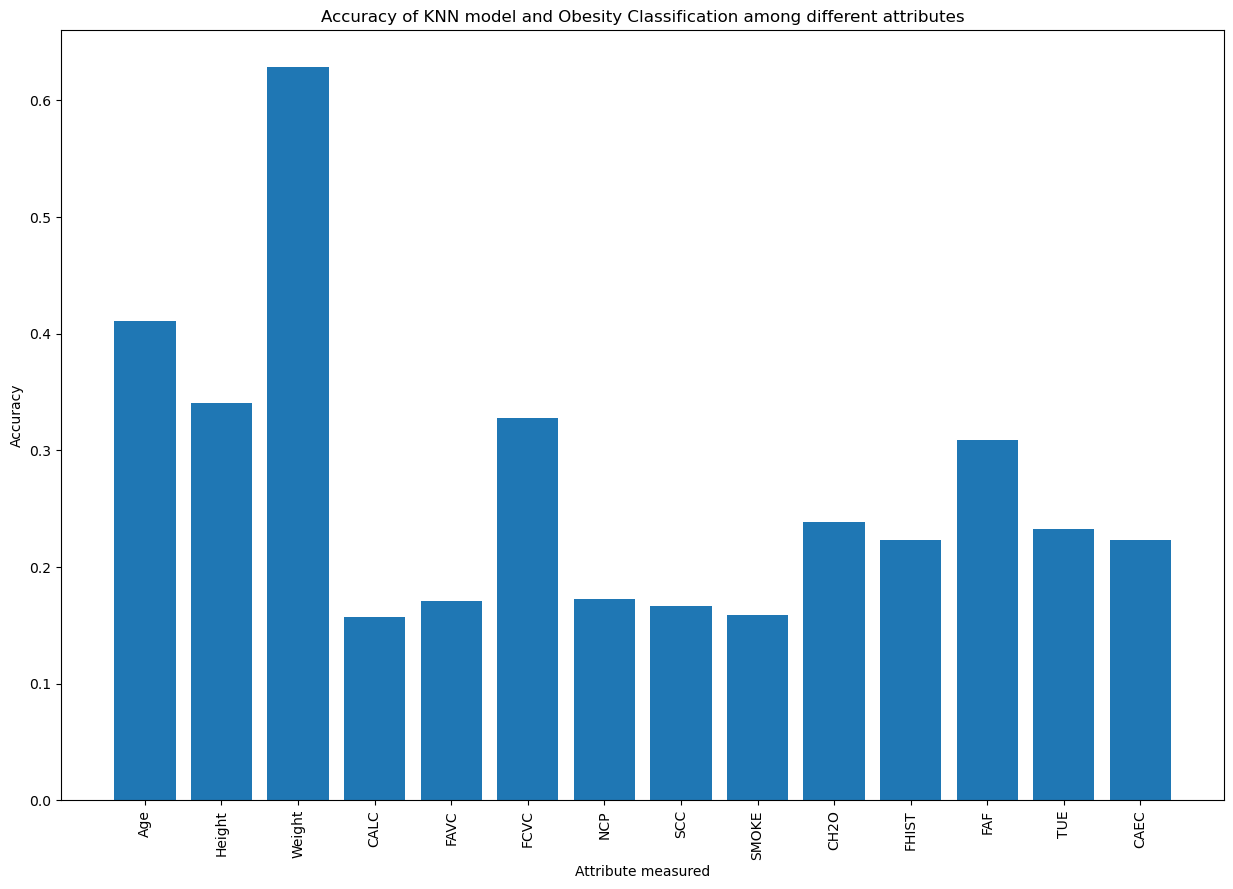

In [16]:
total_accuracies = []
for column in df.columns:
    if column == 'NObeyesdad':
        break
    X_train, X_test, y_train, y_test = train_test_split(df[column].values, df['NObeyesdad'].values, 
                                                        random_state = 12)
    X_train = X_train.reshape(-1,1)
    X_test = X_test.reshape(-1,1)
    knn = KNeighborsClassifier()
    knn.fit(X = X_train, y = y_train)
    y_pred = knn.predict(X = X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    total_accuracies.append(accuracy)

plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
plt.title('Accuracy of KNN model and Obesity Classification among different attributes')
plt.xlabel('Attribute measured')
plt.ylabel('Accuracy')
plt.bar(df.columns[0:14], total_accuracies)

As we can see, it seems that the most accurate choice for predicting Obesity levels is weight, as it produces the highest accuracy using the KNN model. Next, we can plot the accuracy of the KNN model for several K values to determine which is most effective.

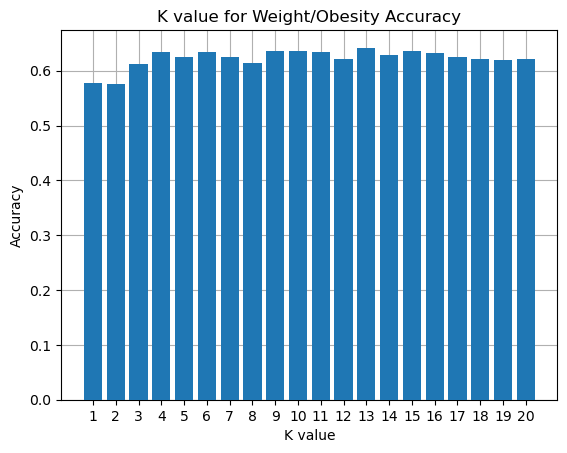

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df['Weight'].values, df['NObeyesdad'].values, 
                                                        random_state = 15)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

weight_accuracies = []
for k in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X = X_train, y = y_train)
    y_pred = knn.predict(X = X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    weight_accuracies.append(accuracy)

x = list(range(1,21))
x = [str(item) for item in x]
fig, ax = plt.subplots(1, 1)
ax.grid(zorder=0)
ax.bar(x ,weight_accuracies, zorder=3)
plt.title('K value for Weight/Obesity Accuracy')
plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.show()

This bar plot has shown that there is a similar level of accuracy for the model, always hovering around the mid 60% range. This suggests some relationship between how weight diagnoses obesity, as different K-values approach the same accuracy range.

# Conclusion

Throughout this project, we've demonstrated and established the various methods by which we can utilize the tools we've learned to apply to different fields, whether those be in wine quality, product review accuracies, or obesity diagnoses, and much, much more. These are just the tip of the iceberg when it comes to the capabilities and tools at hand for a Data Scientist, which just serves as a high motivator and point of interest to seek out more, and to continue to learn!